In [1]:
"""
2025-12-04 Maria Yli-Heikkilä

Fishy results are those that do not have any overlapping years. No conversion (adjustement) is applied.

Plot the results to see how filling NAs with interpolation works.

Here we test how the interpolation method 'linear' (and 'slinear') vs. 'nearest' works. 

"""


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from random import sample

In [2]:
# Interpolated with nearest value in:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/interpolatedNearest/Food-supply-quantity-kg-capita-yr-2023.csv'
df1 = pd.read_csv(fp)
df1['Domain'].value_counts()

Domain
BiasCorrectedAdjusted    1163821
New FBS                    18593
Old FBS                     3455
Interpolated                1349
Name: count, dtype: int64

In [3]:
df1['interpolationMethod'].value_counts()

interpolationMethod
Nearest    1349
Name: count, dtype: int64

In [4]:
# Interpolated with linear method (mean?) in:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/interpolatedLinear/Food-supply-quantity-kg-capita-yr-2023.csv'
df2 = pd.read_csv(fp)
df2['Domain'].unique()

array(['BiasCorrectedAdjusted', 'Interpolated', 'New FBS', 'Old FBS'],
      dtype=object)

In [5]:
df2['interpolationMethod'].value_counts()

interpolationMethod
Linear    1349
Name: count, dtype: int64

In [6]:
# Interpolated with slinear method in:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/interpolatedSlinear/Food-supply-quantity-kg-capita-yr-2023.csv'
df0 = pd.read_csv(fp)
df0['Domain'].unique()

array(['BiasCorrectedAdjusted', 'Interpolated', 'New FBS', 'Old FBS'],
      dtype=object)

In [7]:
df0['interpolationMethod'].value_counts()

interpolationMethod
Slinear    1349
Name: count, dtype: int64

In [8]:
# let's join the three datasets:
df3 = pd.concat([df1, df2, df0], axis = 0, ignore_index = True)
#df3['interpolationMethod'].value_counts()
df3['interpolationMethod'].unique()

array([nan, 'Nearest', 'Linear', 'Slinear'], dtype=object)

In [9]:
# Let's plot some interpolated cases:

uniqueCases = df1[['Area Code', 'Item', 'Domain']].drop_duplicates()
exampleCases = uniqueCases[uniqueCases['Domain'] == 'Interpolated'].reset_index()
len(exampleCases)

583

In [10]:
# prepare dictionaries:
myAreaDict = df1.set_index('Area').to_dict()['Area Code']
myAreaDictReverse = df1.set_index('Area Code').to_dict()['Area']

myItemDict = df1.set_index('Item').to_dict()['Item Code']
myItemDictReverse = df1.set_index('Item Code').to_dict()['Item']

In [47]:

#### FUNC:

# Plot with the best interpolation method
# set the best
def plotting77(data, mycountryCode, myElement, myItem, startingYear, axes, ylabel, huelabel, palette, palette2, bestMethod):
    mycountry = myAreaDictReverse.get(mycountryCode)
    mytitle = mycountry
    # Subset data, choose one of the interpolation methods, default 'linear':
    data22 = data[(data['Area Code'] == mycountryCode) & (data['Element'] == myElement) & (data['Item'] == myItem)]
    #include the best and the original data (na):
    data2 = data22[(data22['interpolationMethod'] == bestMethod) | (data22['interpolationMethod'].isna())]
    

    if data2.empty:
        mytitle = f'Empty dataset for {mycountry}'


    data2 = data2.assign(Time = pd.to_datetime(data2.Year, format='%Y'))

    if startingYear:
        data3 = data2[data2['Year'].astype(int) >= startingYear]
    else:
        data3 = data2


    if data['Unit'][0] == '1000 No':
        unit = '$\\times 10^{3}$'
    else:
        unit = data['Unit'][0]
    #print(data3)
    data33 = data3.drop_duplicates()
    
    dataInterpolated = data33[(data33['interpolationMethod'] == bestMethod)]
    datanotInterpolated = data33[~(data33['interpolationMethod'] == bestMethod)]
    if len(dataInterpolated) == 1:
        # interpolated values are poorly visible in lineplot
        ax = sns.lineplot(datanotInterpolated, y = ylabel, x = 'Time', hue = huelabel, palette=palette, ax = axes)
        # we add points to show the interpolated values:
        sns.scatterplot(ax = ax, data = dataInterpolated, y = ylabel, x = 'Time', hue = huelabel, palette = palette2)
    else:
        ax = sns.lineplot(data33, y = ylabel, x = 'Time', hue = huelabel, palette=palette, ax = axes)
        
        
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'{mytitle}, {myItem}, {bestMethod}')
    ax.set_ylabel(f'{myItem} ({unit})')

        
    return data2.empty
    
    


In [12]:
# plot a closer window of all interpolation methods:
def plotting88(data, mycountryCode, myElement, myItem, axes, ylabel, huelabel, colors):
    original = 'Value'
    mycountry = myAreaDictReverse.get(mycountryCode)
    
    # Subset data:
    data2 = data[(data['Area Code'] == mycountryCode) & (data['Element'] == myElement) & (data['Item'] == myItem)]
    if all(data2['interpolationMethod'].isna()):        
        mytitle = 'No missing values, no need to interpolate.'
        return True
    else:
        #'Continue'

        mytitle = mycountry

        if data2.empty:
            mycountry = f'Empty dataset for {mycountry}'

        # Get the time frame:    
        startingYear = data2[data2['interpolationMethod'] == 'Linear'].Year.min()
        endingYear = data2[data2['interpolationMethod'] == 'Linear'].Year.max()
        #print(startingYear, endingYear)    

        data22 = data2[data2.Year.isin(range(int(startingYear - 2), int(endingYear + 3)))].copy()
        data22 = data22.assign(Time = pd.to_datetime(data22.Year, format='%Y'))

        data22['interpolationMethod'].fillna('Original', inplace=True)
        # Mask head and tail of original to show discontinuety:

        #data22['interpolationMethod'][(data22['interpolationMethod'] == 'Original') & (data22['Year'] <=  startingYear)] = 'Original head'        
        #data22['interpolationMethod'][(data22['interpolationMethod'] == 'Original') & (data22['Year'] >=  endingYear)] = 'Original tail'        
        #print(data22)
        if data['Unit'][0] == '1000 No':
            unit = '$\\times 10^{3}$'
        else:
            unit = data['Unit'][0]

        #print(data22)
        #data333 = data33.drop_duplicates()
        data22 = data22.drop_duplicates()

        data333 = data22[['Time', ylabel, huelabel, original]]

        for huelabel in data333['interpolationMethod'].unique():
            #print(huelabel)
            if huelabel == 'Original':
                datatmp = data333.set_index('Time').sort_index()
                datatmpindex = datatmp.index
                axes.plot(datatmp[original], label = 'None')
            elif huelabel in ['Nearest', 'Linear', 'Slinear']:
                #datatmp2 = data333[data333['interpolationMethod'] == huelabel]
                #datatmp22 = datatmp2.set_index('Time').sort_index()
                #datatmp222 = datatmp22.reindex(datatmpindex)
                #datatmp222['interpolationMethod'] = huelabel
                #axes.plot(datatmp222[ylabel], label = huelabel, linestyle = styles[huelabel], color = colors[huelabel], alpha=0.5)
                
                datatmp2 = data333[(data333['interpolationMethod'] == huelabel)|(data333['interpolationMethod'] == 'Original')]
                datatmp22 = datatmp2.set_index('Time').sort_index()
                datatmp22['interpolationMethod'] = huelabel
                axes.plot(datatmp22[ylabel], label = huelabel, linestyle = styles[huelabel], color = colors[huelabel], alpha=0.7)

            else:
                pass
        axes.tick_params(axis='x', rotation=45)
        axes.legend(title='Interpolation method')        
                
        return False






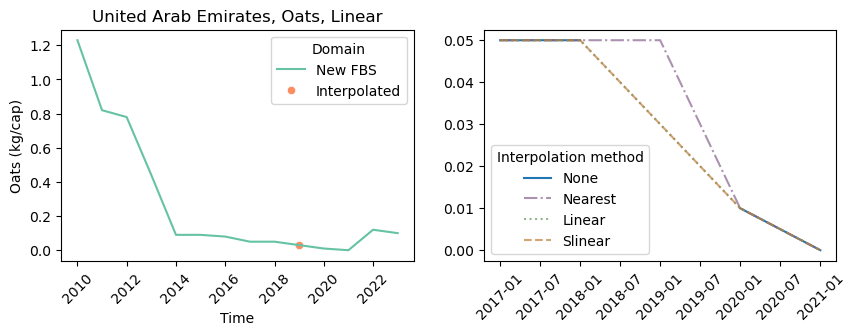

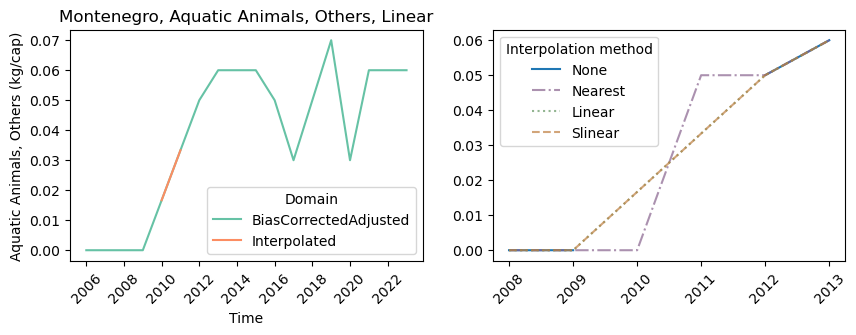

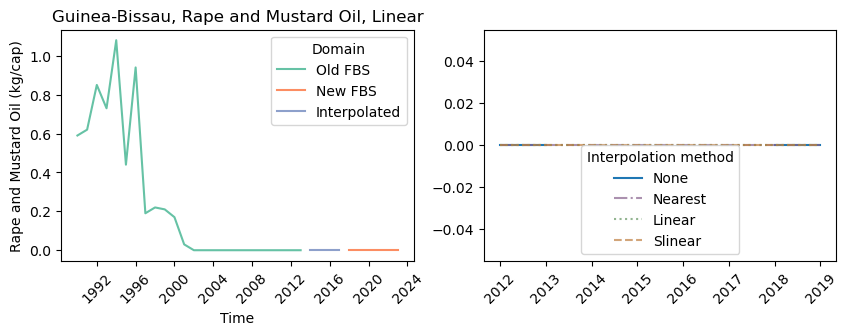

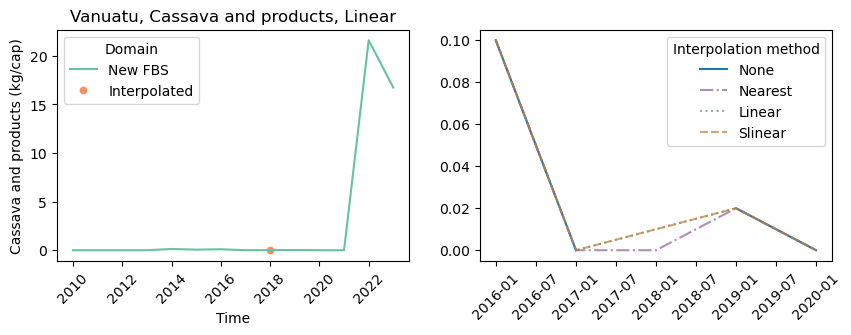

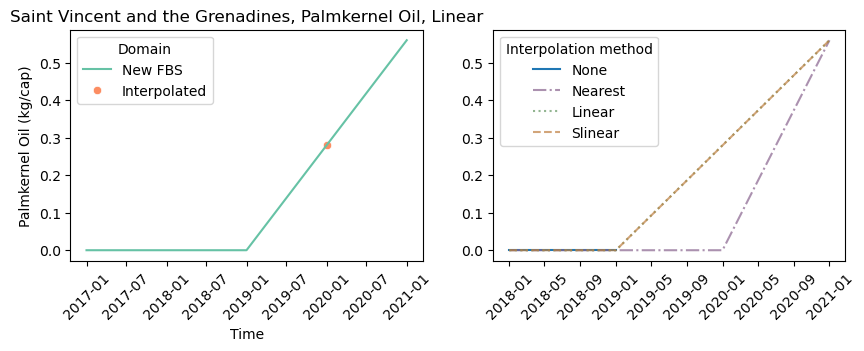

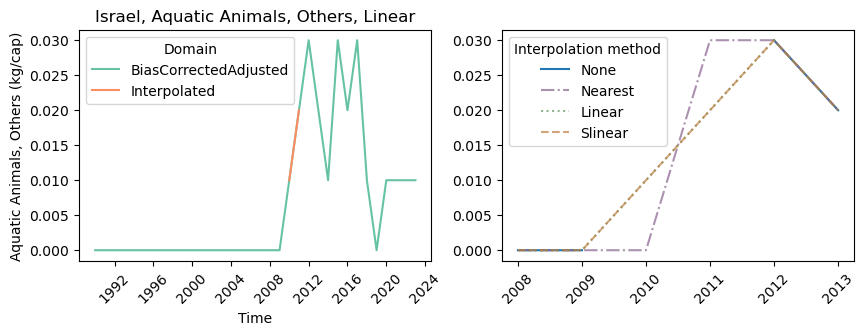

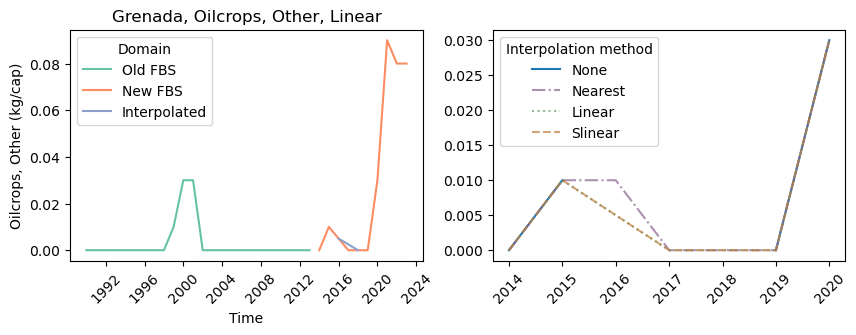

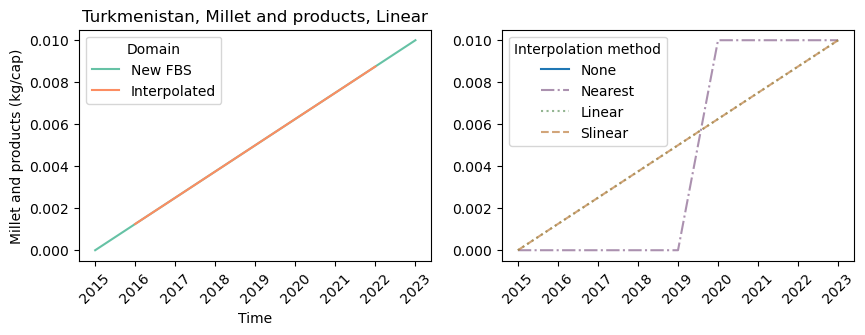

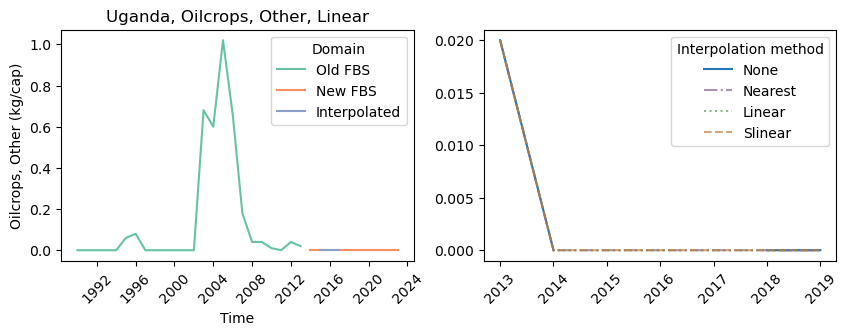

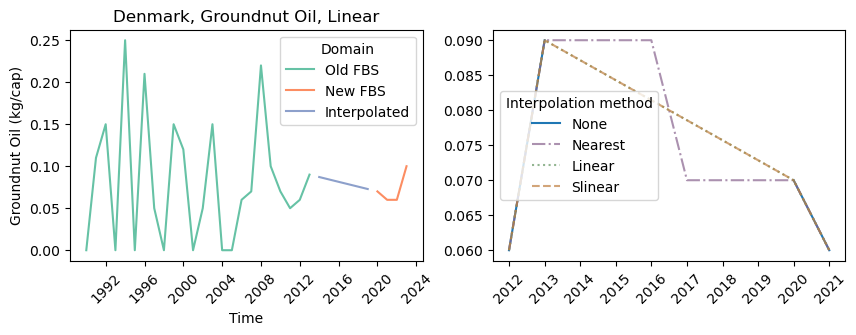

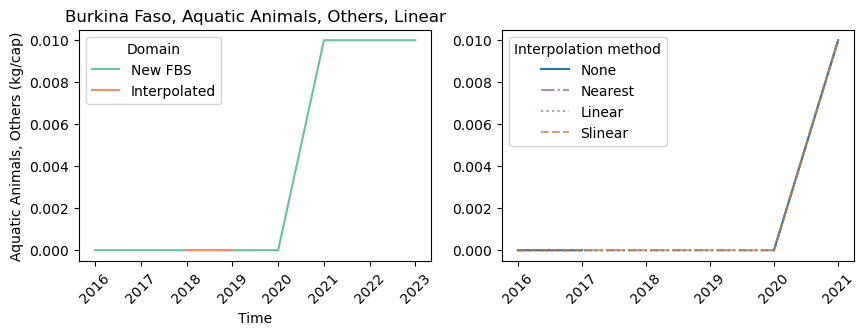

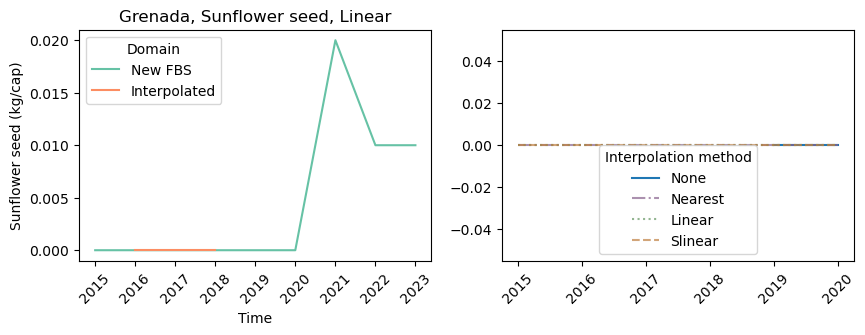

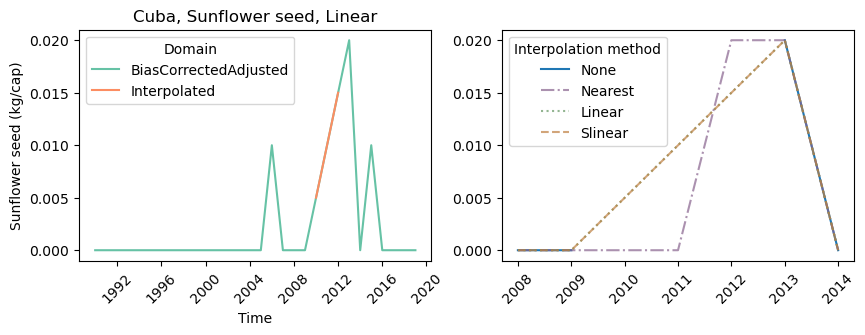

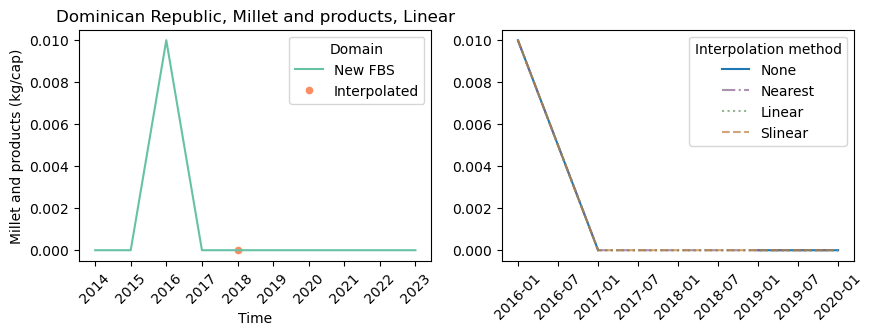

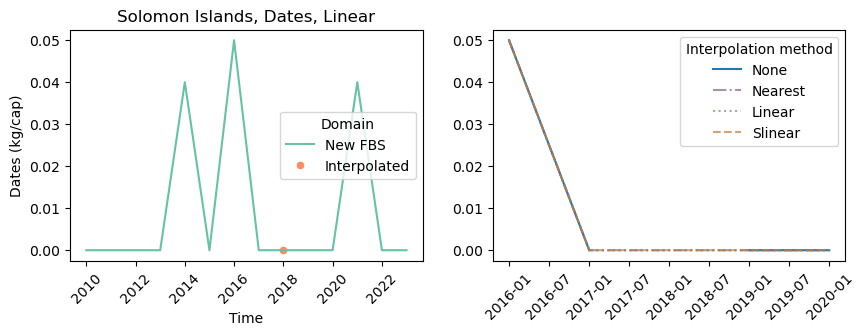

In [50]:
warnings.filterwarnings('ignore')

palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 
myElement = 'Food supply quantity (kg/capita/yr)'
styles = {'Original': '-', 'Original head': '-', 'Original tail': '-', 'Nearest': '-.', 'Linear': ':', 'Slinear': '--'} 
colors = {"Linear": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "Nearest": sns.color_palette("Set1", n_colors=8, desat=.5)[3], 
          "Slinear": sns.color_palette("Set1", n_colors=8, desat=.5)[4]}

for i in sample(range(len(exampleCases)), 30):


    mycountry = exampleCases.iloc[i]['Area Code']
    myItem = exampleCases.iloc[i]['Item']
    #print(mycountry, myItem, myElement)
    
    test0 = df3[(df3['Area Code'] == mycountry) & (df3['Element'] == myElement) & (df3['Item'] == myItem)]
    if test0['Value'].max() > 0:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
        test = plotting77(df3, mycountry, myElement, myItem, 1990, ax1,  'NAsInterpolated', 'Domain', palette1, palette11, 'Linear')
        if not test:
            plotting88(df3, mycountry, myElement, myItem, ax2, 'NAsInterpolated', 'interpolationMethod', colors)
            plt.show
            
    else:
        continue

In [ ]:
Check this: Sri Lanka, Mischellaneous